# Train the neural network

In [5]:
import mxnet as mx
from mxnet import nd, gluon, init, autograd, gpu
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

# Use GPU if one exists, else use CPU
#ctx = mxgpu() if mx.context.num_gpus() else mx.cpu()
ctx = [gpu(0), gpu(1), gpu(2), gpu(3)]

### Get data 

In [6]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
('X shape: ', X.shape, 'X dtype', X.dtype, 'y:', y)

('X shape: ', (28, 28, 1), 'X dtype', numpy.uint8, 'y:', 2)

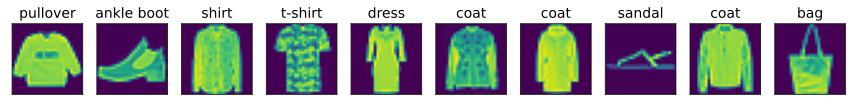

In [7]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = mnist_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

- Gluon model은 입력 이미지를 (c, h, w)의 floating point datatype으로 변환해야함
- `transforms.ToTensor()`로 변환.
- mean 0.13, stadard deviation 0.31로 Normalizaion 진행

In [8]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])
mnist_train = mnist_train.transform_first(transformer)

In [9]:
batch_size = 256
train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


- Load validation dataset

In [11]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

### Define the model

In [12]:
def build_lenet(net):
    net = net
    with net.name_scope():        
        net.add(nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
                nn.MaxPool2D(pool_size=2, strides=2),
                nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
                nn.MaxPool2D(pool_size=2, strides=2),
                nn.Flatten(),
                nn.Dense(120, activation="relu"),
                nn.Dense(84, activation="relu"),
                nn.Dense(10))  
        return net

### Train
- 정확도 계산을 위한 메소드 정의

In [13]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

- 학습 Loop

In [24]:
def train_model(model):
    
    # 가중치 초기화
    # model.initialize(init=init.Xavier(), ctx=ctx)    
    model.collect_params().initialize(init=init.Xavier(), ctx=ctx)
    
    # Loss 정의
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    
    # Optimizer 정의
    trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.1})
    
    for epoch in range(5):
        train_loss, train_acc, valid_acc = 0., 0., 0.
        tic = time.time()
        
        for data, label in train_data:
            data_list = gluon.utils.split_and_load(data, ctx)
            label_list = gluon.utils.split_and_load(label, ctx)
            
            # forward + backward
            with autograd.record():
                '''
                output = model(data)
                loss = softmax_cross_entropy(output, label)
                '''
                losses = [softmax_cross_entropy(model(X), y) for X, y in zip(data_list, label_list)]
            
            for loss in losses:    
                loss.backward()
                
            # update parameters
            trainer.step(batch_size)
            # calculate training metrics
            # train_loss += loss.mean().asscalar()
            train_loss += sum([loss.sum().asscalar() for loss in losses])
            '''
            train_acc += acc(output, label)
        # calculate validation accuracy
        for data, label in valid_data:
            valid_acc += acc(model(data), label)
        print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
                epoch, train_loss/len(train_data), train_acc/len(train_data),
                valid_acc/len(valid_data), time.time()-tic))
        '''
        print("Epoch %d: loss %.3f, in %.1f sec" % (
        epoch, train_loss/len(train_data)/batch_size, time.time()-tic))

In [25]:
model = build_lenet(nn.Sequential())        
train_model(model)

Epoch 0: loss 0.795, in 8.1 sec
Epoch 1: loss 0.465, in 8.0 sec
Epoch 2: loss 0.405, in 8.1 sec
Epoch 3: loss 0.367, in 8.0 sec
Epoch 4: loss 0.342, in 8.1 sec


### Save the Model

In [27]:
model.save_parameters('net.params')

### Save the Model Architecture
- 다른 언어를 통해 Inference를 하기 위해서는 모델의 구조도 함께 저장해야함.
- 모델 구조를 저장을 하려면 `Hybrid` 모델로 정의 해야한다.

In [29]:
model = build_lenet(nn.HybridSequential())
model.hybridize()
train_model(model)

Epoch 0: loss 0.855, in 5.0 sec
Epoch 1: loss 0.500, in 5.0 sec
Epoch 2: loss 0.435, in 5.1 sec
Epoch 3: loss 0.393, in 5.1 sec
Epoch 4: loss 0.365, in 5.1 sec


In [36]:
model.export("lenet", epoch=4)